#CONVOLUTIONAL NEURAL NETWORKS FOR TRYING TO PREDICT BRAIN HEMORRHAGES

The goal is to create a convolutional network that allows 2D slices of brain CTs to be
classified in two classes, depending on the presence of bleeding or not.
We have a database of  CT scans collected from the Near East Hospital, Cyprus and we based our code in this research papper: "Helwan, A., El-Fakhri, G., Sasani, H., & Uzun Ozsahin, D. (2018). Deep networks in identifying CT brain hemorrhage. Journal of Intelligent & Fuzzy Systems, 35(2), 2215-2228."

Firstly we connect our notebook with kaggle to retrieve the database and store it on our drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
#do it just the 1st time
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/kaggle"
%cd /content/drive/My Drive/Colab Notebooks/brain #we come back to the folder where we have our notebook

[Errno 2] No such file or directory: '/content/drive/My Drive/Colab Notebooks/brain #we come back to the folder where we have our notebook'
/content


In [ ]:
!kaggle datasets download -d abdulkader90/brain-ct-hemorrhage-dataset #dowload the database, only do it the first time

brain-ct-hemorrhage-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip brain-ct-hemorrhage-dataset.zip #unzip the folder (also one time only)

Archive:  brain-ct-hemorrhage-dataset.zip
replace Data/Hemorrhagic/KANAMA/11[11]/11_0_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Now that we have all set we can start building our model, firstly we import some libraries and functions and we store our images in a list.

In [ ]:
#GENERAL
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import glob
import tensorflow as tf
from skimage import io
from skimage.transform import resize
import os.path
from pathlib import Path


In [ ]:
tf.__version__

'2.14.0'

In [ ]:
path = Path('/content/drive/My Drive/Colab Notebooks/brain/Data/')
list_images = list(path.glob(r"**/*.jpg"))   #list of all our unzip images
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], list_images))  #separete images (normal and not)

In [ ]:
path_series = pd.Series(list_images, name = "Image").astype(str) #convert into series so that after we can put it in a dataframe (image, status)
labels_series = pd.Series(labels, name = "Status")

In [ ]:
#DATAFRAME
data = pd.concat([path_series, labels_series], axis = 1)

In [ ]:
data

,Image,Status
0,/content/drive/My Drive/Colab Notebooks/brain/...,11[11]
1,/content/drive/My Drive/Colab Notebooks/brain/...,11[11]
2,/content/drive/My Drive/Colab Notebooks/brain/...,11[11]
3,/content/drive/My Drive/Colab Notebooks/brain/...,11[11]
4,/content/drive/My Drive/Colab Notebooks/brain/...,11[11]
...,...,...
6767,/content/drive/My Drive/Colab Notebooks/brain/...,N9[N9]
6768,/content/drive/My Drive/Colab Notebooks/brain/...,N9[N9]
6769,/content/drive/My Drive/Colab Notebooks/brain/...,N9[N9]
6770,/content/drive/My Drive/Colab Notebooks/brain/...,N9[N9]


We already have the dataframe with all the images but Status does not tell us if the image is normal or not, if we look inside our downloaded folder (inside normal and inside hemorrhage) we see that we have the CT each one with a number we are going to rename so that they have if they are normal or not.

Hemorrhage == 1
Normal == 0

In [ ]:
data["Status"].replace({"11[11]":"1","11[11]":"1","12[12]":"1","13[13]":"1",
                               "14[14]":"1","15[15]":"1","17[17]__":"1",
                               "19[19]":"1","1[1]":"1","20[20]_2":"1",
                               "21[21] _2":"1","2[2]":"1","3[3]":"1","4[4]":"1","5[5]":"1",
                               "6[6]":"1","7[7]":"1","8[8]":"1","9[9]":"1"},inplace=True)

In [ ]:
data["Status"].replace({"N10[N10]":"0","N11[N11]":"0","N12[N12]":"0","N13[N13]":"0","N14[N14]":"0",
                               "N15[N15]":"0","N15[N15]":"0",
                               "N16[N16]":"0","N17[N17]":"0","N18[N18]":"0",
                               "N19[N19]":"0","N1[N1]":"0","N20[N20]":"0","N21[N21]":"0",
                               "N22[N22]":"0","N23[N23]":"0","N24[N24]":"0",
                               "N25[N25]":"0","N26[N26]":"0","N27[N27]":"0","N2[N2]":"0",
                               "N3[N3]":"0","N4[N4]":"0","N5[N5]":"0",
                               "N6[N6]":"0","N7[N7]":"0","N8[N8]":"0","N9[N9]":"0"},inplace=True)

This way we can count how many of each we have:

In [ ]:
print(data["Status"].value_counts())

0    4105
1    2667
Name: Status, dtype: int64


In [ ]:
data.describe()

,Image,Status
count,6772,6772
unique,6772,2
top,/content/drive/My Drive/Colab Notebooks/brain/...,0
freq,1,4105


#VISUALIZATION:

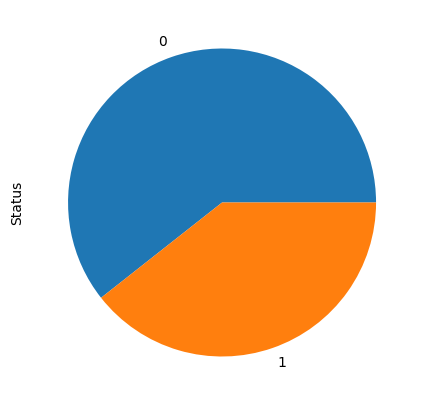

In [ ]:
data['Status'].value_counts().plot.pie(figsize=(5,5))
plt.show()

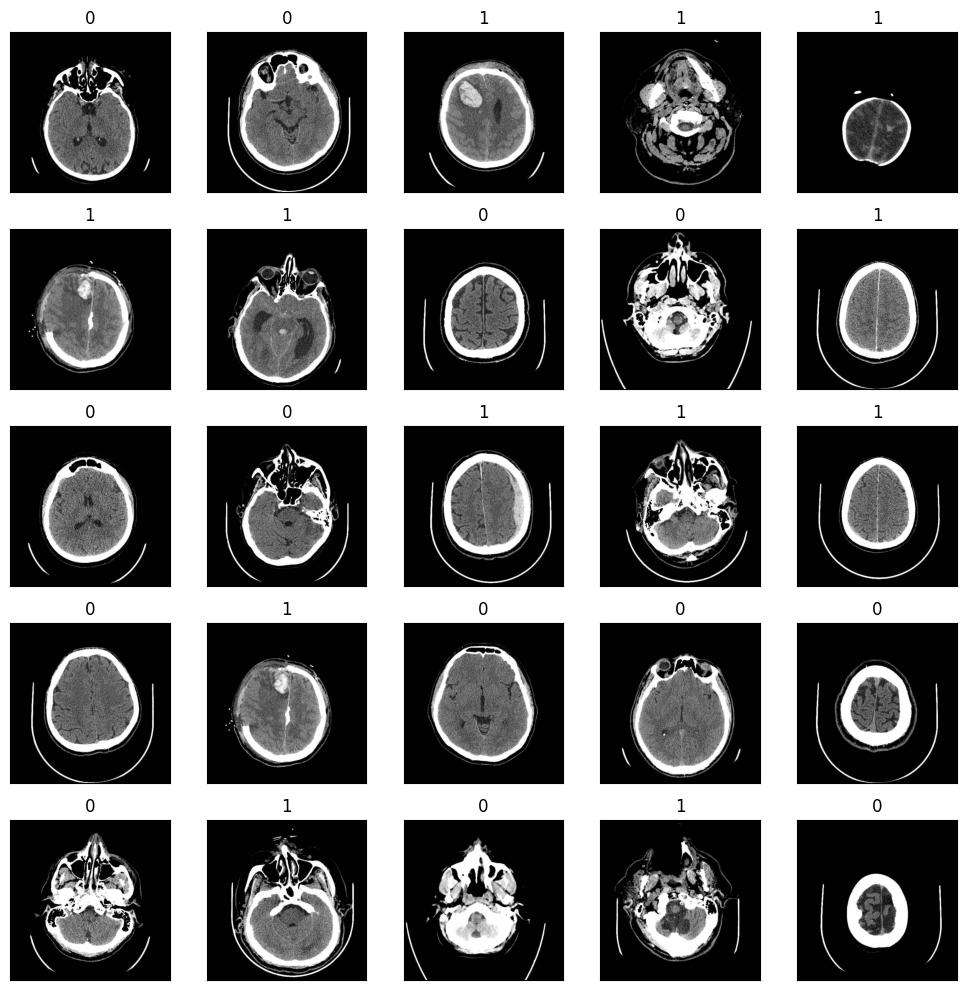

In [ ]:
data = data.sample(frac=1).reset_index(drop=True) #mix them to not have them in order

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(10,10), subplot_kw={"xticks":[],"yticks":[]})
for i,ax in enumerate(ax.flat):
    ax.imshow(plt.imread(data["Image"][i]))
    ax.set_title(data["Status"][i])
plt.tight_layout()
plt.show()

We have a dataframe we have to read the images as such and then split into train test

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, random_state = 0, test_size = 0.2, shuffle = True)
print("TRAIN SHAPE: ",train.shape, '//', "TEST SHAPE: ", test.shape)

TRAIN SHAPE:  (5417, 2) // TEST SHAPE:  (1355, 2)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from keras.preprocessing import image

im_gen = ImageDataGenerator(rescale = 1./255, zoom_range = 0.2, shear_range = 0.2, rotation_range = 40, horizontal_flip = True, fill_mode = "nearest", validation_split = 0.1)
test_gen = ImageDataGenerator(rescale = 1./255)

In [ ]:
data_train = im_gen.flow_from_dataframe(dataframe = train, x_col = "Image", y_col = "Status", color_mode ="grayscale", class_mode = "categorical", subset ="training")
data_test = im_gen.flow_from_dataframe(dataframe = test, x_col = "Image", y_col = "Status", color_mode = "grayscale", class_mode = "categorical")
data_val = im_gen.flow_from_dataframe(dataframe = train, x_col = "Image", y_col = "Status", color_mode = "grayscale", class_mode = "categorical", subset = "validation")

Found 4876 validated image filenames belonging to 2 classes.
Found 1355 validated image filenames belonging to 2 classes.
Found 541 validated image filenames belonging to 2 classes.


In [ ]:
#retrieve shapes of the 3 splits
for data_batch,label_batch in data_train:
    print("Data shape train: ",data_batch.shape)
    print("Label shape train: ",label_batch.shape)
    break
for data_batch,label_batch in data_test:
    print("Data shape test: ",data_batch.shape)
    print("Label shape test: ",label_batch.shape)
    break
for data_batch,label_batch in data_val:
    print("Data shape validation: ",data_batch.shape)
    print("Label shape validation: ",label_batch.shape)
    break

Data shape train:  (32, 256, 256, 1)
Label shape train:  (32, 2)
Data shape test:  (32, 256, 256, 1)
Label shape test:  (32, 2)
Data shape validation:  (32, 256, 256, 1)
Label shape validation:  (32, 2)


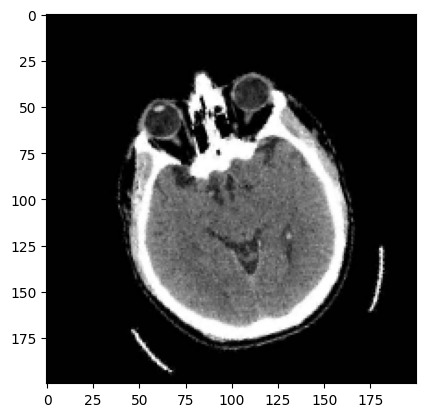

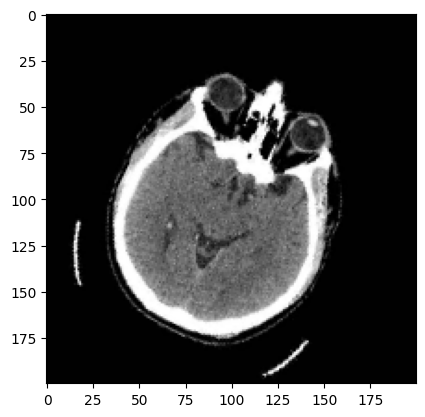

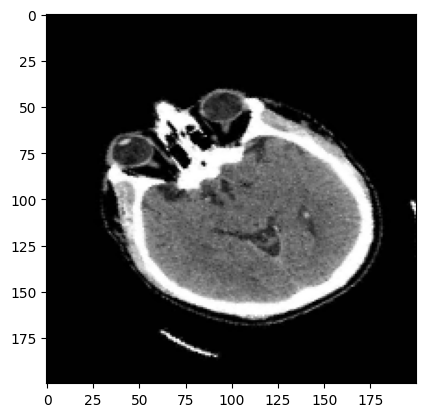

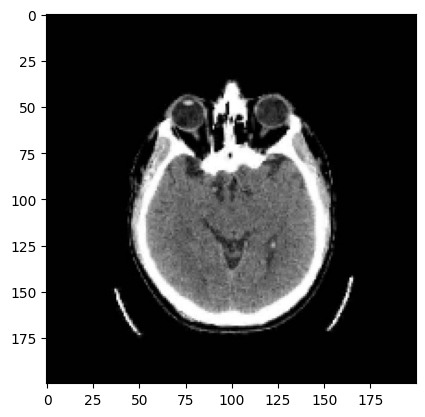

In [ ]:
#see how the image generator works in an example
example_Image = train["Image"][99]
Load_Image = image.load_img(example_Image,target_size=(200,200))
Array_Image = image.img_to_array(Load_Image)
Array_Image = Array_Image.reshape((1,) + Array_Image.shape)

i = 0
for batch in im_gen.flow(Array_Image,batch_size=1):
    plt.figure(i)
    IMG = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()

Now we are going to design our neural network, firstly we will train a simple network and see how it performs. This will take some time.

In [ ]:
from keras.layers import Conv2D, Flatten, MaxPool2D, Dense, Dropout, BatchNormalization, Permute, TimeDistributed, Bidirectional,GRU, SimpleRNN, LSTM, GlobalAveragePooling2D
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
simple_cnn33 = Sequential()
simple_cnn33.add(Conv2D(filters = 12, kernel_size = (3,3), activation = 'relu',input_shape = (256,256,1)))
simple_cnn33.add(BatchNormalization())
simple_cnn33.add(MaxPool2D(pool_size = (2,2)))
simple_cnn33.add(Flatten())
simple_cnn33.add(Dense(2, activation = 'relu')) #output layer

In [ ]:
simple_cnn33.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
simple_cnn33.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 12)      120       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 12)      48        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 12)      0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 193548)            0         
                                                                 
 dense (Dense)               (None, 2)                 387098    
                                                                 
Total params: 387266 (1.48 MB)
Trainable params: 387242 

In [ ]:
early_stopping_monitor = EarlyStopping(monitor = 'accuracy',patience = 2) #si en 2 epochs no mejora el accuracy, se para

In [ ]:
simple_cnn33.fit(data_train, validation_data = data_val, epochs = 15,callbacks = [early_stopping_monitor])
print('Accuracy train: ', simple_cnn33.evaluate(data_train, verbose = 0) [1])
print('Accuracy test: ', simple_cnn33.evaluate(data_test, verbose = 0) [1])

Epoch 1/15
153/153 [==============================] - 343s 2s/step - loss: nan - accuracy: 0.6044 - val_loss: nan - val_accuracy: 0.6248
Epoch 2/15
153/153 [==============================] - 294s 2s/step - loss: nan - accuracy: 0.6044 - val_loss: nan - val_accuracy: 0.6248
Epoch 3/15
153/153 [==============================] - 295s 2s/step - loss: nan - accuracy: 0.6044 - val_loss: nan - val_accuracy: 0.6248
Accuracy train:  0.6043888330459595
Accuracy test:  0.6051660776138306


As we can see we need to  improve accuracy, based on previous research we will use LSTM* networks and GRU (Gated recurrent units), these are used to put past information in the future to reduce the problem of gradient destruction.

*LSTMs (Long Short-Term Memory) are a special kind of RNN (Recurrent neural networks), capable of learning long-term dependencies. We use LSTM to capture the chronological information attained from the Time Distributed layers above and get meaningful information out of it.

*GRU (Gated Recurrent Unit) aims to solve the vanishing gradient problem which comes with a standard recurrent neural network.

In [ ]:
cnn2 = Sequential()
cnn2.add(Conv2D(filters = 12, kernel_size = (3,3), activation="relu", input_shape=(256,256,1)))
cnn2.add(BatchNormalization())
cnn2.add(MaxPool2D((2,2)))

#same as before
#now we add more hidden layers

cnn2.add(Conv2D(filters = 24,kernel_size = (3,3), activation = 'relu', padding = 'same'))
cnn2.add(Dropout(.2)) #ignores 20%
cnn2.add(MaxPool2D((2,2)))

cnn2.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
cnn2.add(Dropout(.5)) #ignores 50%
cnn2.add(MaxPool2D((2,2)))

#explicamos abajo
cnn2.add(TimeDistributed(Flatten())) #flatten each output to send all outputs with one dimension to LSTM
cnn2.add(Bidirectional(LSTM(32, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))) #to Capture the Sequencial Information
cnn2.add(Bidirectional(GRU(32, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))) #solve gradient problem

cnn2.add(Flatten())
cnn2.add(Dense(256,activation = 'relu'))
cnn2.add(Dropout(.5)) #ignora el 50%
cnn2.add(Dense(2, activation = 'softmax')) #output layer

Dropout == regularization
Dropout is a technique where randomly selected neurons are ignored during training. They are “dropped out” randomly. This means that their contribution to the activation of downstream neurons is temporally removed on the forward pass, and any weight updates are not applied to the neuron on the backward pass.

Time distributed layer == no increase complexity. This Specialized Layer applies the same layer to several inputs and get output for each input such that we can combine them and pass it to another layer to make predictions.



https://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [ ]:
cnn2.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
print(cnn2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 12)      120       
                                                                 
 batch_normalization_1 (Bat  (None, 254, 254, 12)      48        
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 12)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 127, 127, 24)      2616      
                                                                 
 dropout_3 (Dropout)         (None, 127, 127, 24)      0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 63, 63, 24)       

In [ ]:
early_stopping_monitor = EarlyStopping(monitor = "loss", patience = 5,mode = "min") #stop cuando el loss value es minimo

In [ ]:
modelo_final = cnn2.fit(data_train,validation_data = data_val, epochs = 40,callbacks = [early_stopping_monitor])

Epoch 1/40
153/153 [==============================] - 1322s 9s/step - loss: 0.7291 - accuracy: 0.5880 - val_loss: 0.6862 - val_accuracy: 0.5749
Epoch 2/40
153/153 [==============================] - 288s 2s/step - loss: 0.6513 - accuracy: 0.6202 - val_loss: 0.6680 - val_accuracy: 0.5767
Epoch 3/40
153/153 [==============================] - 286s 2s/step - loss: 0.6488 - accuracy: 0.6192 - val_loss: 0.6661 - val_accuracy: 0.6081
Epoch 4/40
153/153 [==============================] - 289s 2s/step - loss: 0.6456 - accuracy: 0.6401 - val_loss: 0.6535 - val_accuracy: 0.6192
Epoch 5/40
153/153 [==============================] - 290s 2s/step - loss: 0.6395 - accuracy: 0.6364 - val_loss: 0.6552 - val_accuracy: 0.6155
Epoch 6/40
153/153 [==============================] - 291s 2s/step - loss: 0.6352 - accuracy: 0.6425 - val_loss: 0.6463 - val_accuracy: 0.6285
Epoch 7/40
153/153 [==============================] - 290s 2s/step - loss: 0.6324 - accuracy: 0.6454 - val_loss: 0.6357 - val_accuracy: 0.611

We will now save our model and plot some results, then the GUI based on this model is designed.

In [ ]:
cnn2.save('trading_model.h5')
cnn2.save('model.keras')
cnn2.save(path) #we save it on our path in drive

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from keras.models import load_model
modelo_final = load_model("traning_model.h5")

In [ ]:
print('Accuracy train: ', modelo_final.evaluate(data_train, verbose = 0) [1])
print('Accuracy test: ', modelo_final.evaluate(data_test, verbose = 0) [1])

Accuracy train:  0.8816652894020081
Accuracy test:  0.8833948373794556


In [ ]:
prediction = modelo_final.predict(data_test)
prediction = prediction.argmax(axis = -1)

43/43 [==============================] - 28s 613ms/step


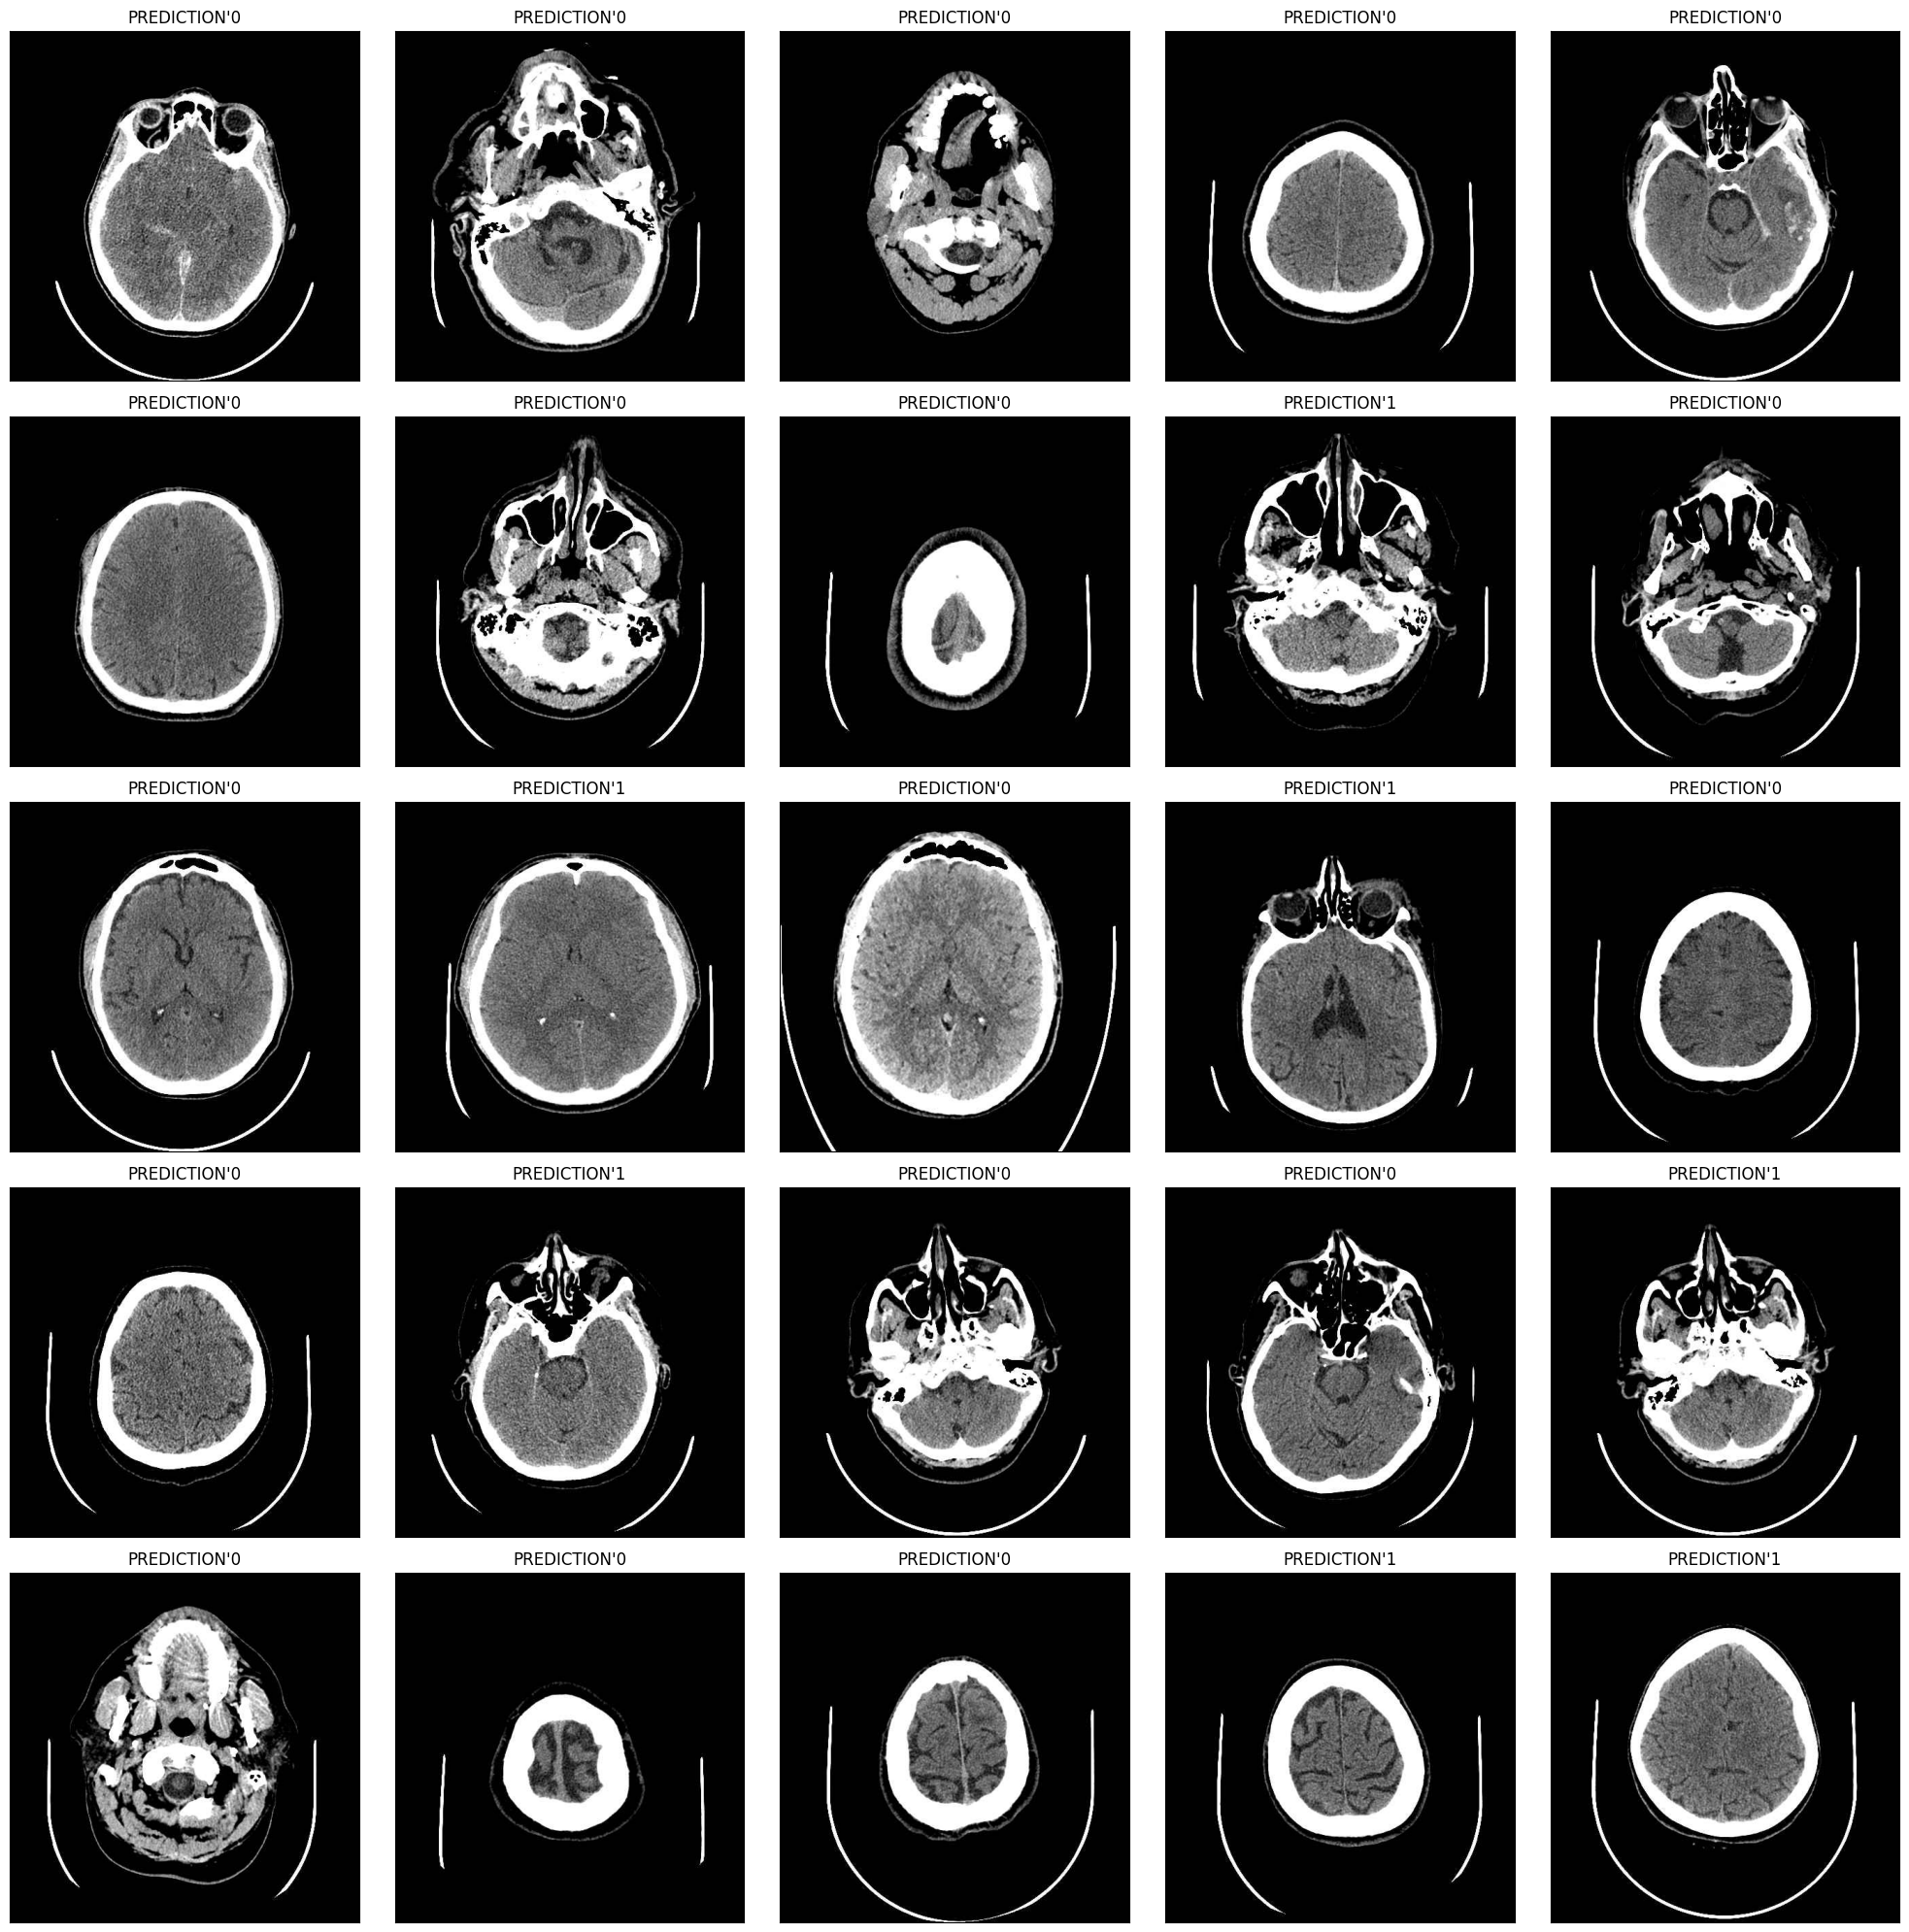

In [ ]:
fig, axes = plt.subplots(nrows = 5, ncols = 5,figsize = (20, 20), subplot_kw = {'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test["Image"].iloc[i]))
    ax.set_title(f"PREDICTION'{prediction[i]}")
plt.tight_layout()
plt.show()